# I-JEPA

Code consolidated into one notebook (for Kaggle training) from https://github.com/facebookresearch/ijepa. However, custom adaptions have been made in terms of the data processing, masking and the overall new learning objective needed in this project for making I-JEPA (an image SSL model) usable for time series based predictions.

## Imports

In [ ]:
# core train
import os
import copy
import sys
import numpy as np
import torch
import torch.nn.functional as F
import yaml
import math
from functools import partial
import torch.nn as nn

## Config

In [2]:
# Basic global config
_GLOBAL_SEED = 0
np.random.seed(_GLOBAL_SEED)
torch.manual_seed(_GLOBAL_SEED)
torch.backends.cudnn.benchmark = True

In [3]:
args = {
    "data": {
        "batch_size": 8,
        "image_folders": ['/kaggle/input/fmri-train-1-norm-v3/data/noisy_func_train_1.npy',
                '/kaggle/input/fmri-train-2-norm-v3/data/noisy_func_train_2.npy',
                '/kaggle/input/fmri-train-3-norm-v3/data/noisy_func_train_3.npy'],
        "validation_folders": ['/kaggle/input/fmri-val-norm-v3/data/noisy_func_val.npy'],
        "num_workers": 2,
        "pin_mem": True,
        "root_path": "/kaggle/input",
        "use_horizontal_flip": False
    },
    "logging": {
        "folder": "/kaggle/working/logs",
        "write_tag": "jepa"
    },
    "mask": {
        "allow_overlap": False,
        "aspect_ratio": [0.75, 1.5],
        "enc_mask_scale": [0.85, 1.0],
        "min_keep": 10,
        "num_enc_masks": 1,
        "num_pred_masks": 1,
        "patch_size": 16,
        "pred_mask_scale": [0.15, 0.2]
    },
    "meta": {
        "copy_data": False,
        "load_checkpoint": False,
        "model_name": "vit_small",
        "pred_depth": 12,
        "pred_emb_dim": 384,
        "read_checkpoint": "/kaggle/input/jepa-14x14/pytorch/default/1/IN1K-vit.h.14-300e.pth.tar",
        "use_bfloat16": True
    },
    "optimization": {
        "ema": [0.996, 1.0],
        "epochs": 25,
        "final_lr": 1.0e-5,
        "final_weight_decay": 0.4,
        "ipe_scale": 1.0,
        "lr": 0.001,
        "start_lr": 0.0002,
        "warmup": 50,
        "weight_decay": 0.04
    }
}


In [4]:
resume_preempt = False
rank = 0

# -- META
use_bfloat16 = args['meta']['use_bfloat16']
model_name = args['meta']['model_name']
load_model = args['meta']['load_checkpoint'] or resume_preempt
r_file = args['meta']['read_checkpoint']
copy_data = args['meta']['copy_data']
pred_depth = args['meta']['pred_depth']
pred_emb_dim = args['meta']['pred_emb_dim']
if not torch.cuda.is_available():
    device = torch.device('cpu')
else:
    device = torch.device('cuda:0')
    torch.cuda.set_device(device)

# -- DATA
batch_size = args['data']['batch_size']
pin_mem = args['data']['pin_mem']
num_workers = args['data']['num_workers']
root_path = args['data']['root_path']
image_folders = args['data']['image_folders']
validation_folders = args['data']['validation_folders']
# --

# -- MASK
allow_overlap = args['mask']['allow_overlap']  # whether to allow overlap b/w context and target blocks
patch_size = args['mask']['patch_size']  # patch-size for model training
num_enc_masks = args['mask']['num_enc_masks']  # number of context blocks
min_keep = args['mask']['min_keep']  # min number of patches in context block
enc_mask_scale = args['mask']['enc_mask_scale']  # scale of context blocks
num_pred_masks = args['mask']['num_pred_masks']  # number of target blocks
pred_mask_scale = args['mask']['pred_mask_scale']  # scale of target blocks
aspect_ratio = args['mask']['aspect_ratio']  # aspect ratio of target blocks
# --

# -- OPTIMIZATION
ema = args['optimization']['ema']
ipe_scale = args['optimization']['ipe_scale']  # scheduler scale factor (def: 1.0)
wd = float(args['optimization']['weight_decay'])
final_wd = float(args['optimization']['final_weight_decay'])
num_epochs = args['optimization']['epochs']
warmup = args['optimization']['warmup']
start_lr = args['optimization']['start_lr']
lr = args['optimization']['lr']
final_lr = args['optimization']['final_lr']

# -- LOGGING
folder = args['logging']['folder']
tag = args['logging']['write_tag']

os.makedirs(folder, exist_ok=True)
dump = os.path.join(folder, 'params-ijepa.yaml')
with open(dump, 'w') as f:
    yaml.dump(args, f)

## Logging

In [5]:
import logging
log_timings = True
log_freq = 10
checkpoint_freq = 1
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logger = logging.getLogger()

In [6]:
def gpu_timer(closure, log_timings=True):
    """ Helper to time gpu-time to execute closure() """
    log_timings = log_timings and torch.cuda.is_available()

    elapsed_time = -1.
    if log_timings:
        start = torch.cuda.Event(enable_timing=True)
        end = torch.cuda.Event(enable_timing=True)
        start.record()

    result = closure()

    if log_timings:
        end.record()
        torch.cuda.synchronize()
        elapsed_time = start.elapsed_time(end)

    return result, elapsed_time

In [7]:
class CSVLogger(object):

    def __init__(self, fname, *argv):
        self.fname = fname
        self.types = []
        # -- print headers
        with open(self.fname, '+a') as f:
            for i, v in enumerate(argv, 1):
                self.types.append(v[0])
                if i < len(argv):
                    print(v[1], end=',', file=f)
                else:
                    print(v[1], end='\n', file=f)

    def log(self, *argv):
        with open(self.fname, '+a') as f:
            for i, tv in enumerate(zip(self.types, argv), 1):
                end = ',' if i < len(argv) else '\n'
                print(tv[0] % tv[1], end=end, file=f)


class AverageMeter(object):
    """computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.max = float('-inf')
        self.min = float('inf')
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        try:
            self.max = max(val, self.max)
            self.min = min(val, self.min)
        except Exception:
            pass
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [8]:
# -- log/checkpointing paths
log_file = os.path.join(folder, f'{tag}_r{rank}.csv')
save_path = os.path.join(folder, f'{tag}' + '-ep{epoch}.pth.tar')
latest_path = os.path.join(folder, f'{tag}-latest.pth.tar')
load_path = None
if load_model:
    load_path = os.path.join(folder, r_file) if r_file is not None else latest_path

# csv logger
csv_logger = CSVLogger(log_file,
                       ('%d', 'epoch'),
                       ('%d', 'itr'),
                       ('%.5f', 'train_loss'),
                       ('%.5f', 'val_loss'),  # Added validation loss
                       ('%.5f', 'mask-A'),
                       ('%.5f', 'mask-B'),
                       ('%d', 'time (ms)'))

## Dataset creation and preprocessing

### Data transformation

#### Masking (with custom-designed TimeSeriesMaskCollator)

In [9]:
import math
from multiprocessing import Value

In [10]:
class TimeSeriesMaskCollator:
    def __init__(self, num_frames=300, frame_size=16, nenc=1, npred=1):
        self.num_frames = num_frames
        self.frame_size = frame_size
        self._itr_counter = Value('i', -1)
        self.npred = 1
        self.nenc = 1

    def step(self):
        i = self._itr_counter
        with i.get_lock():
            i.value += 1
            v = i.value
        return v
    
    def collate_merge_batches(self, batch):
        merged = torch.cat([item for item in batch], dim=0)
        return merged

    def _sample_frame_mask(self, generator, exclude_frames=None):
        # Build list of available frame indices
        choices = torch.tensor(
            [i for i in range(self.num_frames) if (exclude_frames is None or i not in exclude_frames)],
            dtype=torch.long
        )
        # Sample one index using the generator
        idx = torch.randint(0, len(choices), (1,), generator=generator).item()
        frame_idx = choices[idx]

        mask = torch.zeros(self.num_frames, dtype=torch.int32)
        mask[frame_idx] = 1
        mask = torch.nonzero(mask.flatten()).squeeze()
        return mask, frame_idx

    def build_encoder_mask_from_pred(self, pred_masks):
        enc_mask = torch.ones(self.num_frames, dtype=torch.int32)
        for pred_mask in pred_masks:
            enc_mask[pred_mask] = 0  # Zero out the masked regions
        return torch.nonzero(enc_mask.flatten()).squeeze()

    def __call__(self, batch):
        collated_batch = self.collate_merge_batches(batch)
        B = collated_batch.shape[0]

        seed = self.step()
        g = torch.Generator()
        g.manual_seed(seed)

        collated_masks_enc, collated_masks_pred = [], []

        for _ in range(B):
            pred_masks = []
            pred_frame_idxs = []
            for _ in range(self.npred):
                mask, idx = self._sample_frame_mask(generator=g, exclude_frames=pred_frame_idxs)
                pred_masks.append(mask)
                pred_frame_idxs.append(idx)

            collated_masks_pred.append(pred_masks)

            enc_masks = []
            for _ in range(self.nenc):
                enc_mask = self.build_encoder_mask_from_pred(pred_masks)
                enc_masks.append(enc_mask)

            collated_masks_enc.append(enc_masks)

        collated_masks_pred = torch.utils.data.default_collate(collated_masks_pred)
        collated_masks_enc = torch.utils.data.default_collate(collated_masks_enc)

        return collated_batch, collated_masks_enc, collated_masks_pred


In [11]:
def apply_masks(x, masks):
    """
    :param x: tensor of shape [B (batch-size), N (num-patches), D (feature-dim)]
    :param masks: list of tensors containing indices of patches in [N] to keep
    """
    all_x = []
    for m in masks:
        mask_keep = m.unsqueeze(-1).repeat(1, 1, x.size(-1))
        all_x += [torch.gather(x, dim=1, index=mask_keep)]
    return torch.cat(all_x, dim=0)

In [12]:
mask_collator = TimeSeriesMaskCollator() # defaults to 300 frames of size 16x16

#### Image transforms

In [13]:
import numpy as np
import torch # Import PyTorch

class Compose:
    """
    Composes several transforms together.
    Args:
        transforms (list of callables): list of transforms to compose.
    """
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img_array):
        """
        Applies the composed transforms to the input array.
        The input can be a NumPy array. The output will be a torch.Tensor
        if torch.from_numpy is the last transform.
        Args:
            img_array (numpy.ndarray): Input image array (C, H, W).
        Returns:
            torch.Tensor: Transformed image tensor.
        """
        for t in self.transforms:
            img_array = t(img_array) # Note: img_array will become a torch.Tensor at the end
        return img_array


# Build the transform list
transform_list = []

def reshape_to_2d_timeline(patch_time_series):
    # Convert to PyTorch tensor immediately for permute/reshape
    patch_time_series_tensor = torch.from_numpy(patch_time_series).float()
    height_patch = patch_time_series_tensor.shape[0]  # H
    width_patch = patch_time_series_tensor.shape[1]   # W
    total_time_steps = patch_time_series_tensor.shape[2]  # T   

    # print(patch_time_series_tensor.shape)

    
    # Apply the corrected reshaping logic here
    # Original tensor shape (H, W, T) -> (16, 16, total_time_steps)
    # Permute to (H, T, W)
    intermediate_tensor = patch_time_series_tensor.permute(0, 2, 1)
    
    sample = intermediate_tensor.reshape(height_patch, total_time_steps * width_patch)

    # Add a channel dimension: (1, H, T*W)
    sample = sample.unsqueeze(0)
    return sample
    #return patch_time_series_tensor

transform_list += [reshape_to_2d_timeline]  # Add reshape transform
transform_list += [lambda x: x.unsqueeze(0)] # add batch dimension

# Composition of transforms
transform = Compose(transform_list)

### Dataset & Dataloader

In [14]:
import random

In [15]:
class NoisyDataset(torch.utils.data.Dataset):
    def __init__(self, noisy_images_paths: list, transform=None, normalize=True):
        """Initialize fMRI dataset for denoising with memory-efficient loading,
        extracting 16x16 patches with full time series per depth channel.

        Args:
            noisy_images_paths (list): List of paths to noisy fMRI volumes (.npy files)
            stats: Dictionary containing 'mean' and 'std' for normalization.
            transform (callable, optional): Optional transform to be applied on a sample.
            normalize (bool): Whether to apply channel-wise normalization.
        """
        self.noisy_paths = noisy_images_paths
        self.transform = transform
        self.normalize = normalize

        self.file_slice_mapping = [] # Stores (file_idx, z_idx, patch_y_idx, patch_x_idx)

        patch_size = 16
        dataset_length = 0

        for i, path in enumerate(noisy_images_paths):
            # Load metadata about the file shape without loading full content
            data_shape = np.load(path, mmap_mode='r').shape
            # Assuming data_shape is (H, W, Z, T)
            total_height, total_width, depth_channels, total_time_steps = data_shape

            # Calculate how many patches fit along each spatial dimension
            num_patches_width = total_width // patch_size
            num_patches_height = total_height // patch_size

            # Iterate over all depth channels (Z)
            for z_idx in range(depth_channels):
                # Iterate through the spatial grid of patches
                for patch_y_idx in range(num_patches_height):
                    for patch_x_idx in range(num_patches_width):
                        # Each combination of (file, z_idx, patch_y_idx, patch_x_idx) is a unique item
                        self.file_slice_mapping.append((i, z_idx, patch_y_idx, patch_x_idx))
                        dataset_length += 1

        self.data_len = dataset_length
        self.patch_size = patch_size # Store patch_size for __getitem__

    def __len__(self):
        return self.data_len

    def __getitem__(self, index):

        valid_patch = False
        while valid_patch == False:
            # Use the mapping to determine which file, depth channel, and spatial patch to load
            file_idx, z_idx, patch_y_idx, patch_x_idx = self.file_slice_mapping[index]
    
            # Load data from the specific file
            noisy_file_path = self.noisy_paths[file_idx]
    
            # Load the full 4D array with mmap_mode to avoid loading everything into RAM
            noisy_volume = np.load(noisy_file_path, mmap_mode='r')
    
            # Calculate the starting and ending coordinates for the current patch
            start_h = patch_y_idx * self.patch_size
            end_h = start_h + self.patch_size
            start_w = patch_x_idx * self.patch_size
            end_w = start_w + self.patch_size
    
            # Extract the 16x16 patch for the specific depth channel (z_idx)
            # and include the entire time series.
            # The resulting shape will be (patch_size, patch_size, time_steps)
            patch_time_series = noisy_volume[start_h:end_h, start_w:end_w, z_idx, :].copy()

            patch = patch_time_series[:,:,0]
            patch_sum = np.sum(patch)
            if patch_sum >= -25:
                valid_patch = True
            else:
                index = random.randint(0, self.data_len-1)
            

        # Apply transformations if specified
        if self.transform is not None:
            # Your transform should expect a tensor of shape (C, H, W, T) or (H, W, T)
            # depending on how you structure it. Adjust accordingly.
            sample = self.transform(patch_time_series)

        return sample

In [16]:
# dataset
dataset = NoisyDataset(noisy_images_paths=image_folders, transform=transform, normalize=True)

In [17]:
val_dataset = NoisyDataset(noisy_images_paths=validation_folders, transform=transform, normalize=True)

In [ ]:
data_loader = torch.utils.data.DataLoader(
    dataset,
    collate_fn=mask_collator,
    batch_size=batch_size,
    drop_last=True,
    pin_memory=pin_mem,
    num_workers=num_workers,
    persistent_workers=False)

ipe = len(data_loader)

In [ ]:
val_loader = torch.utils.data.DataLoader(
    val_dataset,
    collate_fn=mask_collator,
    batch_size=batch_size,
    drop_last=True,
    pin_memory=pin_mem,
    num_workers=num_workers,
    persistent_workers=False)

## Train

#### Dataset inspection

In [18]:
dataset[100].shape

torch.Size([1, 1, 16, 4800])

In [19]:
dataset[1].max()

tensor(2.8980)

In [20]:
# import numpy as np
# import matplotlib.pyplot as plt

# # Create a 64x64 tensor with random values (can be negative)
# tensor = dataset[900]
# tensor = tensor.detach().cpu().numpy()

# # Output tensor: initialized with NaNs for discarded patches (visually blank)
# visualized = np.full_like(tensor, np.nan)

# patch_size = 16
# for i in range(0, 64, patch_size):
#     for j in range(0, 64, patch_size):
#         patch = tensor[i:i+patch_size, j:j+patch_size]
#         patch_sum = np.sum(patch)

#         if patch_sum >= -25:
#             visualized[i:i+patch_size, j:j+patch_size] = patch
#         # else: keep as NaN for blank display

# # Display: use masked array to make NaNs invisible in the colormap
# masked = np.ma.masked_invalid(visualized)

# plt.figure(figsize=(6, 6))
# plt.imshow(masked, cmap='gray')
# plt.title("Visible Patches (sum >= 0)")
# plt.axis('off')
# plt.colorbar(label='Value Intensity')
# plt.show()


In [21]:
dataset[1][:][:][:].shape

torch.Size([1, 1, 16, 4800])

In [22]:
dataset[0][0].permute(2,0,1)[0].shape

torch.Size([1, 16])

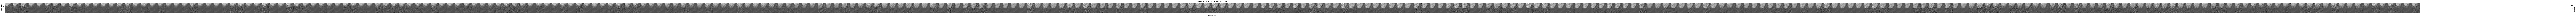

In [23]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Create a dummy tensor of the specified size for demonstration.
# In your actual code, this would be your loaded image tensor.
# Using torch.rand to get values between 0 and 1, suitable for image display.
image_tensor = dataset[1012][0][0]

# Convert the PyTorch tensor to a NumPy array.
# Use .detach().cpu().numpy() if your tensor is on a GPU or requires gradients.
image_np = image_tensor.detach().cpu().numpy()

plt.figure(figsize=(480, 1.6)) # Adjust figure size for a wide, short image

# Display the image
# 'cmap="gray"' or 'cmap="Greys_r"' is standard for grayscale images.
# 'aspect="auto"' allows the image to stretch to fill the figure, which is helpful
# for unusual aspect ratios like 16x4800.
plt.imshow(image_np, cmap='gray', aspect='auto') 

plt.title('Visualization of a 16x4800 Grayscale Image')
plt.xlabel('Width (pixels)')
plt.ylabel('Height (pixels)')
plt.colorbar(label='Pixel Intensity') # Add a colorbar to show intensity mapping
plt.savefig("fig_new.png")
plt.show()


### Model backbone (vision transformer)

In [29]:
def _no_grad_trunc_normal_(tensor, mean, std, a, b):
    # Cut & paste from PyTorch official master until it's in a few official releases - RW
    # Method based on https://people.sc.fsu.edu/~jburkardt/presentations/truncated_normal.pdf
    def norm_cdf(x):
        # Computes standard normal cumulative distribution function
        return (1. + math.erf(x / math.sqrt(2.))) / 2.

    with torch.no_grad():
        # Values are generated by using a truncated uniform distribution and
        # then using the inverse CDF for the normal distribution.
        # Get upper and lower cdf values
        l = norm_cdf((a - mean) / std)
        u = norm_cdf((b - mean) / std)

        # Uniformly fill tensor with values from [l, u], then translate to
        # [2l-1, 2u-1].
        tensor.uniform_(2 * l - 1, 2 * u - 1)

        # Use inverse cdf transform for normal distribution to get truncated
        # standard normal
        tensor.erfinv_()

        # Transform to proper mean, std
        tensor.mul_(std * math.sqrt(2.))
        tensor.add_(mean)

        # Clamp to ensure it's in the proper range
        tensor.clamp_(min=a, max=b)
        return tensor


def trunc_normal_(tensor, mean=0., std=1., a=-2., b=2.):
    # type: (Tensor, float, float, float, float) -> Tensor
    return _no_grad_trunc_normal_(tensor, mean, std, a, b)


def repeat_interleave_batch(x, B, repeat):
    N = len(x) // B
    x = torch.cat([
        torch.cat([x[i*B:(i+1)*B] for _ in range(repeat)], dim=0)
        for i in range(N)
    ], dim=0)
    return x

In [30]:
def get_2d_sincos_pos_embed(embed_dim, grid_size, cls_token=False):
    """
    grid_size: int of the grid height and width
    return:
    pos_embed: [grid_size*grid_size, embed_dim] or [1+grid_size*grid_size, embed_dim] (w/ or w/o cls_token)
    """
    grid_h = np.arange(grid_size, dtype=float)
    grid_w = np.arange(grid_size, dtype=float)
    grid = np.meshgrid(grid_w, grid_h)  # here w goes first
    grid = np.stack(grid, axis=0)

    grid = grid.reshape([2, 1, grid_size, grid_size])
    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)
    if cls_token:
        pos_embed = np.concatenate([np.zeros([1, embed_dim]), pos_embed], axis=0)
    return pos_embed


def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):
    assert embed_dim % 2 == 0

    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)

    emb = np.concatenate([emb_h, emb_w], axis=1)  # (H*W, D)
    return emb


def get_1d_sincos_pos_embed(embed_dim, grid_size, cls_token=False):
    """
    grid_size: int of the grid length
    return:
    pos_embed: [grid_size, embed_dim] or [1+grid_size, embed_dim] (w/ or w/o cls_token)
    """
    grid = np.arange(grid_size, dtype=float)
    pos_embed = get_1d_sincos_pos_embed_from_grid(embed_dim, grid)
    if cls_token:
        pos_embed = np.concatenate([np.zeros([1, embed_dim]), pos_embed], axis=0)
    return pos_embed


def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    """
    embed_dim: output dimension for each position
    pos: a list of positions to be encoded: size (M,)
    out: (M, D)
    """
    assert embed_dim % 2 == 0
    omega = np.arange(embed_dim // 2, dtype=float)
    omega /= embed_dim / 2.
    omega = 1. / 10000**omega   # (D/2,)

    pos = pos.reshape(-1)   # (M,)
    out = np.einsum('m,d->md', pos, omega)   # (M, D/2), outer product

    emb_sin = np.sin(out)  # (M, D/2)
    emb_cos = np.cos(out)  # (M, D/2)

    emb = np.concatenate([emb_sin, emb_cos], axis=1)  # (M, D)
    return emb


def drop_path(x, drop_prob: float = 0., training: bool = False):
    if drop_prob == 0. or not training:
        return x
    keep_prob = 1 - drop_prob
    shape = (x.shape[0],) + (1,) * (x.ndim - 1)  # work with diff dim tensors, not just 2D ConvNets
    random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
    random_tensor.floor_()  # binarize
    output = x.div(keep_prob) * random_tensor
    return output


class DropPath(nn.Module):
    """Drop paths (Stochastic Depth) per sample  (when applied in main path of residual blocks).
    """
    def __init__(self, drop_prob=None):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training)


class MLP(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x, attn


class Block(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(
            dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = MLP(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

    def forward(self, x, return_attention=False):
        y, attn = self.attn(self.norm1(x))
        if return_attention:
            return attn
        x = x + self.drop_path(y)
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x


class PatchEmbed(nn.Module):
    """ Image to Patch Embedding
    """
    def __init__(self, timeline_pixel_width=16*300, patch_size=16, in_chans=1, embed_dim=768):
        super().__init__()
        num_patches = timeline_pixel_width // patch_size
        self.patch_size = patch_size
        self.num_patches = num_patches

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        B, C, H, W = x.shape
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x


class ConvEmbed(nn.Module):
    """
    3x3 Convolution stems for ViT following ViTC models
    """

    def __init__(self, channels, strides, img_size=224, in_chans=1, batch_norm=True):
        super().__init__()
        # Build the stems
        stem = []
        channels = [in_chans] + channels
        for i in range(len(channels) - 2):
            stem += [nn.Conv2d(channels[i], channels[i+1], kernel_size=3,
                               stride=strides[i], padding=1, bias=(not batch_norm))]
            if batch_norm:
                stem += [nn.BatchNorm2d(channels[i+1])]
            stem += [nn.ReLU(inplace=True)]
        stem += [nn.Conv2d(channels[-2], channels[-1], kernel_size=1, stride=strides[-1])]
        self.stem = nn.Sequential(*stem)

        # Comptute the number of patches
        stride_prod = int(np.prod(strides))
        self.num_patches = (img_size[0] // stride_prod)**2

    def forward(self, x):
        p = self.stem(x)
        return p.flatten(2).transpose(1, 2)


class VisionTransformerPredictor(nn.Module):
    """ Vision Transformer """
    def __init__(
        self,
        num_patches,
        embed_dim=768,
        predictor_embed_dim=384,
        depth=6,
        num_heads=12,
        mlp_ratio=4.0,
        qkv_bias=True,
        qk_scale=None,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        drop_path_rate=0.0,
        norm_layer=nn.LayerNorm,
        init_std=0.02,
        **kwargs
    ):
        super().__init__()
        self.predictor_embed = nn.Linear(embed_dim, predictor_embed_dim, bias=True)
        self.mask_token = nn.Parameter(torch.zeros(1, 1, predictor_embed_dim))
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]  # stochastic depth decay rule
        # --
        self.predictor_pos_embed = nn.Parameter(torch.zeros(1, num_patches, predictor_embed_dim),
                                                requires_grad=False)
        predictor_pos_embed = get_1d_sincos_pos_embed(self.predictor_pos_embed.shape[-1],
                                                      int(num_patches),
                                                      cls_token=False)
        self.predictor_pos_embed.data.copy_(torch.from_numpy(predictor_pos_embed).float().unsqueeze(0))
        # --
        self.predictor_blocks = nn.ModuleList([
            Block(
                dim=predictor_embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
                drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[i], norm_layer=norm_layer)
            for i in range(depth)])
        self.predictor_norm = norm_layer(predictor_embed_dim)
        self.predictor_proj = nn.Linear(predictor_embed_dim, embed_dim, bias=True)
        # ------
        self.init_std = init_std
        trunc_normal_(self.mask_token, std=self.init_std)
        self.apply(self._init_weights)
        self.fix_init_weight()

    def fix_init_weight(self):
        def rescale(param, layer_id):
            param.div_(math.sqrt(2.0 * layer_id))

        for layer_id, layer in enumerate(self.predictor_blocks):
            rescale(layer.attn.proj.weight.data, layer_id + 1)
            rescale(layer.mlp.fc2.weight.data, layer_id + 1)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=self.init_std)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            trunc_normal_(m.weight, std=self.init_std)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

    def forward(self, x, masks_x, masks):
        assert (masks is not None) and (masks_x is not None), 'Cannot run predictor without mask indices'

        if not isinstance(masks_x, list):
            masks_x = [masks_x]

        if not isinstance(masks, list):
            masks = [masks]

        # -- Batch Size
        B = len(x) // len(masks_x)

        # -- map from encoder-dim to pedictor-dim
        x = self.predictor_embed(x)

        # -- add positional embedding to x tokens
        x_pos_embed = self.predictor_pos_embed.repeat(B, 1, 1)
        x += apply_masks(x_pos_embed, masks_x)

        _, N_ctxt, D = x.shape

        # -- concat mask tokens to x
        pos_embs = self.predictor_pos_embed.repeat(B, 1, 1)
        pos_embs = apply_masks(pos_embs, masks)
        pos_embs = repeat_interleave_batch(pos_embs, B, repeat=len(masks_x))
        # --
        pred_tokens = self.mask_token.repeat(pos_embs.size(0), pos_embs.size(1), 1)
        # --
        pred_tokens += pos_embs
        x = x.repeat(len(masks), 1, 1)
        x = torch.cat([x, pred_tokens], dim=1)

        # -- fwd prop
        for blk in self.predictor_blocks:
            x = blk(x)
        x = self.predictor_norm(x)

        # -- return preds for mask tokens
        x = x[:, N_ctxt:]
        x = self.predictor_proj(x)

        return x


class VisionTransformer(nn.Module):
    """ Vision Transformer """
    def __init__(
        self,
        timeline_pixel_width=(16*300),
        patch_size=16,
        in_chans=1,
        embed_dim=768,
        predictor_embed_dim=384,
        depth=12,
        predictor_depth=12,
        num_heads=12,
        mlp_ratio=4.0,
        qkv_bias=True,
        qk_scale=None,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        drop_path_rate=0.0,
        norm_layer=nn.LayerNorm,
        init_std=0.02,
        **kwargs
    ):
        super().__init__()
        self.num_features = self.embed_dim = embed_dim
        self.num_heads = num_heads
        # --
        self.patch_embed = PatchEmbed(
            timeline_pixel_width=timeline_pixel_width,
            patch_size=patch_size,
            in_chans=in_chans,
            embed_dim=embed_dim)
        num_patches = self.patch_embed.num_patches
        # --
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim), requires_grad=False)
        pos_embed = get_1d_sincos_pos_embed(self.pos_embed.shape[-1],
                                            int(self.patch_embed.num_patches),
                                            cls_token=False)
        self.pos_embed.data.copy_(torch.from_numpy(pos_embed).float().unsqueeze(0))
        # --
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]  # stochastic depth decay rule
        self.blocks = nn.ModuleList([
            Block(
                dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
                drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[i], norm_layer=norm_layer)
            for i in range(depth)])
        self.norm = norm_layer(embed_dim)
        # ------
        self.init_std = init_std
        self.apply(self._init_weights)
        self.fix_init_weight()

    def fix_init_weight(self):
        def rescale(param, layer_id):
            param.div_(math.sqrt(2.0 * layer_id))

        for layer_id, layer in enumerate(self.blocks):
            rescale(layer.attn.proj.weight.data, layer_id + 1)
            rescale(layer.mlp.fc2.weight.data, layer_id + 1)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=self.init_std)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            trunc_normal_(m.weight, std=self.init_std)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

    def forward(self, x, masks=None):
        if masks is not None:
            if not isinstance(masks, list):
                masks = [masks]

        # -- patchify x
        x = self.patch_embed(x)
        B, N, D = x.shape

        # -- add positional embedding to x
        pos_embed = self.interpolate_pos_encoding(x, self.pos_embed)
        x = x + pos_embed

        # -- mask x
        if masks is not None:
            x = apply_masks(x, masks)

        # -- fwd prop
        for i, blk in enumerate(self.blocks):
            x = blk(x)

        if self.norm is not None:
            x = self.norm(x)

        return x

    def interpolate_pos_encoding(self, x, pos_embed):
        npatch = x.shape[1] - 1
        N = pos_embed.shape[1] - 1
        if npatch == N:
            return pos_embed
        class_emb = pos_embed[:, 0]
        pos_embed = pos_embed[:, 1:]
        dim = x.shape[-1]
        pos_embed = nn.functional.interpolate(
            pos_embed.reshape(1, int(math.sqrt(N)), int(math.sqrt(N)), dim).permute(0, 3, 1, 2),
            scale_factor=math.sqrt(npatch / N),
            mode='bicubic',
        )
        pos_embed = pos_embed.permute(0, 2, 3, 1).view(1, -1, dim)
        return torch.cat((class_emb.unsqueeze(0), pos_embed), dim=1)


def vit_predictor(**kwargs):
    model = VisionTransformerPredictor(
        mlp_ratio=4, qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6),
        **kwargs)
    return model


def vit_tiny(patch_size=16, **kwargs):
    model = VisionTransformer(
        patch_size=patch_size, embed_dim=192, depth=12, num_heads=3, mlp_ratio=4,
        qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model


def vit_small(patch_size=16, **kwargs):
    model = VisionTransformer(
        patch_size=patch_size, embed_dim=384, depth=12, num_heads=6, mlp_ratio=4,
        qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model


def vit_base(patch_size=16, **kwargs):
    model = VisionTransformer(
        patch_size=patch_size, embed_dim=768, depth=12, num_heads=12, mlp_ratio=4,
        qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model


def vit_large(patch_size=16, **kwargs):
    model = VisionTransformer(
        patch_size=patch_size, embed_dim=1024, depth=24, num_heads=16, mlp_ratio=4,
        qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model


def vit_huge(patch_size=16, **kwargs):
    model = VisionTransformer(
        patch_size=patch_size, embed_dim=1280, depth=32, num_heads=16, mlp_ratio=4,
        qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model


def vit_giant(patch_size=16, **kwargs):
    model = VisionTransformer(
        patch_size=patch_size, embed_dim=1408, depth=40, num_heads=16, mlp_ratio=48/11,
        qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model


VIT_EMBED_DIMS = {
    'vit_tiny': 192,
    'vit_small': 384,
    'vit_base': 768,
    'vit_large': 1024,
    'vit_huge': 1280,
    'vit_giant': 1408,
}

### Helper functions

In [31]:
def load_checkpoint(
    device,
    r_path,
    encoder,
    predictor,
    target_encoder,
    opt,
    scaler,
    excluded_layers = None
):

    checkpoint = torch.load(r_path, map_location=torch.device('cpu'))
    epoch = checkpoint['epoch']

    # -- loading encoder with filtering
    pretrained_dict = checkpoint['encoder']
    
    # Remove 'module.' prefix if it exists
    new_pretrained_dict = {}
    for k, v in pretrained_dict.items():
        if k.startswith('module.'):
            new_pretrained_dict[k[7:]] = v  # Remove 'module.' prefix
        else:
            new_pretrained_dict[k] = v
    pretrained_dict = new_pretrained_dict
    
    # Apply excluded_layers filtering
    if excluded_layers != None:
        filtered_dict = {k: v for k, v in pretrained_dict.items() 
                        if not any(keyword in k for keyword in excluded_layers)}
        print(f"Excluded {len(pretrained_dict) - len(filtered_dict)} parameters containing: {excluded_layers}")
        logger.info(f"Excluded {len(pretrained_dict) - len(filtered_dict)} parameters containing: {excluded_layers}")
        pretrained_dict = filtered_dict
    msg = encoder.load_state_dict(pretrained_dict, strict=False)
    print(f'loaded pretrained encoder from epoch {epoch} with msg: {msg}')
    logger.info(f'loaded pretrained encoder from epoch {epoch} with msg: {msg}')

    # -- loading predictor
    pretrained_dict = checkpoint['predictor']
    
    # Remove 'module.' prefix if it exists
    new_pretrained_dict = {}
    for k, v in pretrained_dict.items():
        if k.startswith('module.'):
            new_pretrained_dict[k[7:]] = v  # Remove 'module.' prefix
        else:
            new_pretrained_dict[k] = v
    pretrained_dict = new_pretrained_dict

    # Apply excluded_layers filtering
    if excluded_layers != None:
        filtered_dict = {k: v for k, v in pretrained_dict.items() 
                        if not any(keyword in k for keyword in excluded_layers)}
        print(f"Excluded {len(pretrained_dict) - len(filtered_dict)} parameters containing: {excluded_layers}")
        logger.info(f"Excluded {len(pretrained_dict) - len(filtered_dict)} parameters containing: {excluded_layers}")
        pretrained_dict = filtered_dict

    msg = predictor.load_state_dict(pretrained_dict, strict=False)
    logger.info(f'loaded pretrained predictor from epoch {epoch} with msg: {msg}')

    # -- loading target_encoder
    if target_encoder is not None:
        pretrained_dict = checkpoint['target_encoder']
        
        # Remove 'module.' prefix if it exists
        new_pretrained_dict = {}
        for k, v in pretrained_dict.items():
            if k.startswith('module.'):
                new_pretrained_dict[k[7:]] = v  # Remove 'module.' prefix
            else:
                new_pretrained_dict[k] = v
        pretrained_dict = new_pretrained_dict
        
        if excluded_layers != None:
            filtered_dict = {k: v for k, v in pretrained_dict.items() 
                            if not any(keyword in k for keyword in excluded_layers)}
            logger.info(f"Excluded {len(pretrained_dict) - len(filtered_dict)} parameters containing: {excluded_layers}")
            pretrained_dict = filtered_dict

        msg = target_encoder.load_state_dict(pretrained_dict, strict=False)
        logger.info(f'loaded pretrained target_encoder from epoch {epoch} with msg: {msg}')

    # -- loading optimizer (no need to modify keys for optimizer)
    opt.load_state_dict(checkpoint['opt'])
    if scaler is not None and 'scaler' in checkpoint:
        scaler.load_state_dict(checkpoint['scaler'])
    logger.info(f'loaded optimizers from epoch {epoch}')
    logger.info(f'read-path: {r_path}')
    del checkpoint

    # except Exception as e:
    #     logger.info(f'Encountered exception when loading checkpoint: {e}')
    #     epoch = 0

    return encoder, predictor, target_encoder, opt, scaler, epoch



def init_model(
    device,
    patch_size=16,
    model_name='vit_base',
    timeline_pixel_width=16*300,
    pred_depth=6,
    pred_emb_dim=384
):
    encoder = vit_small(
        timeline_pixel_width=timeline_pixel_width,
        patch_size=patch_size)
    predictor = vit_predictor(
        num_patches=encoder.patch_embed.num_patches,
        embed_dim=encoder.embed_dim,
        predictor_embed_dim=pred_emb_dim,
        depth=pred_depth,
        num_heads=encoder.num_heads)

    def init_weights(m):
        if isinstance(m, torch.nn.Linear):
            trunc_normal_(m.weight, std=0.02)
            if m.bias is not None:
                torch.nn.init.constant_(m.bias, 0)
        elif isinstance(m, torch.nn.LayerNorm):
            torch.nn.init.constant_(m.bias, 0)
            torch.nn.init.constant_(m.weight, 1.0)

    for m in encoder.modules():
        init_weights(m)

    for m in predictor.modules():
        init_weights(m)

    encoder.to(device)
    predictor.to(device)
    logger.info(encoder)
    return encoder, predictor


def init_opt(
    encoder,
    predictor,
    iterations_per_epoch,
    start_lr,
    ref_lr,
    warmup,
    num_epochs,
    wd=1e-6,
    final_wd=1e-6,
    final_lr=0.0,
    use_bfloat16=False,
    ipe_scale=1.25
):
    param_groups = [
        {
            'params': (p for n, p in encoder.named_parameters()
                       if ('bias' not in n) and (len(p.shape) != 1))
        }, {
            'params': (p for n, p in predictor.named_parameters()
                       if ('bias' not in n) and (len(p.shape) != 1))
        }, {
            'params': (p for n, p in encoder.named_parameters()
                       if ('bias' in n) or (len(p.shape) == 1)),
            'WD_exclude': True,
            'weight_decay': 0
        }, {
            'params': (p for n, p in predictor.named_parameters()
                       if ('bias' in n) or (len(p.shape) == 1)),
            'WD_exclude': True,
            'weight_decay': 0
        }
    ]

    logger.info('Using AdamW')
    optimizer = torch.optim.AdamW(param_groups)
    scheduler = WarmupCosineSchedule(
        optimizer,
        warmup_steps=int(warmup*iterations_per_epoch),
        start_lr=start_lr,
        ref_lr=ref_lr,
        final_lr=final_lr,
        T_max=int(ipe_scale*num_epochs*iterations_per_epoch))
    wd_scheduler = CosineWDSchedule(
        optimizer,
        ref_wd=wd,
        final_wd=final_wd,
        T_max=int(ipe_scale*num_epochs*iterations_per_epoch))
    scaler = torch.cuda.amp.GradScaler() if use_bfloat16 else None
    return optimizer, scaler, scheduler, wd_scheduler

In [38]:
class WarmupCosineSchedule(object):

    def __init__(
        self,
        optimizer,
        warmup_steps,
        start_lr,
        ref_lr,
        T_max,
        last_epoch=-1,
        final_lr=0.
    ):
        self.optimizer = optimizer
        self.start_lr = start_lr
        self.ref_lr = ref_lr
        self.final_lr = final_lr
        self.warmup_steps = warmup_steps
        self.T_max = T_max - warmup_steps
        self._step = 0.

    def step(self):
        self._step += 1
        if self._step < self.warmup_steps:
            progress = float(self._step) / float(max(1, self.warmup_steps))
            new_lr = self.start_lr + progress * (self.ref_lr - self.start_lr)
        else:
            # -- progress after warmup
            progress = float(self._step - self.warmup_steps) / float(max(1, self.T_max))
            new_lr = max(self.final_lr,
                         self.final_lr + (self.ref_lr - self.final_lr) * 0.5 * (1. + math.cos(math.pi * progress)))

        for group in self.optimizer.param_groups:
            group['lr'] = new_lr

        return new_lr


class CosineWDSchedule(object):

    def __init__(
        self,
        optimizer,
        ref_wd,
        T_max,
        final_wd=0.
    ):
        self.optimizer = optimizer
        self.ref_wd = ref_wd
        self.final_wd = final_wd
        self.T_max = T_max
        self._step = 0.

    def step(self):
        self._step += 1
        progress = self._step / self.T_max
        new_wd = self.final_wd + (self.ref_wd - self.final_wd) * 0.5 * (1. + math.cos(math.pi * progress))

        if self.final_wd <= self.ref_wd:
            new_wd = max(self.final_wd, new_wd)
        else:
            new_wd = min(self.final_wd, new_wd)

        for group in self.optimizer.param_groups:
            if ('WD_exclude' not in group) or not group['WD_exclude']:
                group['weight_decay'] = new_wd
        return new_wd

### Initializing model

In [39]:
# -- init model
encoder, predictor = init_model(
    device=device,
    patch_size=patch_size,
    timeline_pixel_width=300*16,
    pred_depth=pred_depth,
    pred_emb_dim=pred_emb_dim,
    model_name=model_name)
target_encoder = copy.deepcopy(encoder)

Commented out code stems from the attempt to load pretrained weights, which was not possible due to GPU not supporting the required ViT huge encoder backbone

In [40]:
# load_model = True

In [ ]:
# r_path = load_path

# checkpoint = torch.load(r_path, map_location=torch.device('cpu'))
# epoch = checkpoint['epoch']

# # -- loading encoder with filtering
# pretrained_dict = checkpoint['encoder']

# # Remove 'module.' prefix if it exists
# new_pretrained_dict = {}
# for k, v in pretrained_dict.items():
#     if k.startswith('module.'):
#         new_pretrained_dict[k[7:]] = v  # Remove 'module.' prefix
#     else:
#         new_pretrained_dict[k] = v
# pretrained_dict = new_pretrained_dict

# excluded_layers = ["pos_embed", "patch_embed"]

# filtered_dict = {k: v for k, v in pretrained_dict.items() 
#                 if not any(keyword in k for keyword in excluded_layers)}
# print(f"Excluded {len(pretrained_dict) - len(filtered_dict)} parameters containing: {excluded_layers}")
# logger.info(f"Excluded {len(pretrained_dict) - len(filtered_dict)} parameters containing: {excluded_layers}")
# pretrained_dict = filtered_dict


In [41]:
# -- init optimizer and scheduler
optimizer, scaler, scheduler, wd_scheduler = init_opt(
    encoder=encoder,
    predictor=predictor,
    wd=wd,
    final_wd=final_wd,
    start_lr=start_lr,
    ref_lr=lr,
    final_lr=final_lr,
    iterations_per_epoch=ipe,
    warmup=warmup,
    num_epochs=num_epochs,
    ipe_scale=ipe_scale,
    use_bfloat16=use_bfloat16)
    # encoder = DistributedDataParallel(encoder, static_graph=True)
    # predictor = DistributedDataParallel(predictor, static_graph=True)
    # target_encoder = DistributedDataParallel(target_encoder)
for p in target_encoder.parameters():
    p.requires_grad = False

# -- momentum schedule
momentum_scheduler = (ema[0] + i*(ema[1]-ema[0])/(ipe*num_epochs*ipe_scale)
                      for i in range(int(ipe*num_epochs*ipe_scale)+1))

start_epoch = 0
# -- load training checkpoint
if load_model:
    encoder, predictor, target_encoder, optimizer, scaler, start_epoch = load_checkpoint(
        device=device,
        r_path=load_path,
        encoder=encoder,
        predictor=predictor,
        target_encoder=target_encoder,
        opt=optimizer,
        scaler=scaler,
        excluded_layers = ["pos_embed", "patch_embed"])
    # for _ in range(start_epoch*ipe):
    #     scheduler.step()
    #     wd_scheduler.step()
    #     next(momentum_scheduler)
    #     mask_collator.step()

def save_checkpoint(epoch):
    save_dict = {
        'encoder': encoder.state_dict(),
        'predictor': predictor.state_dict(),
        'target_encoder': target_encoder.state_dict(),
        'opt': optimizer.state_dict(),
        'scaler': None if scaler is None else scaler.state_dict(),
        'epoch': epoch,
        'loss': loss_meter.avg,
        'batch_size': batch_size,
        'lr': lr
    }
    if rank == 0:
        torch.save(save_dict, latest_path) 
        if (epoch + 1) % checkpoint_freq == 0:
            torch.save(save_dict, save_path.format(epoch=f'{epoch + 1}'))

/tmp/ipykernel_19/3605133585.py:186: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_bfloat16 else None


In [43]:
def validate(epoch):
    """Run validation on the validation dataset and return average loss."""
    logger.info('Running validation...')
    val_loss_meter = AverageMeter()
    val_maskA_meter = AverageMeter()
    val_maskB_meter = AverageMeter()
    val_time_meter = AverageMeter()
    
    # Set models to eval mode
    encoder.eval()
    predictor.eval()
    target_encoder.eval()
    
    with torch.no_grad():
        for itr, (udata, masks_enc, masks_pred) in enumerate(val_loader):
            # Load and process images
            imgs = udata.to(device, non_blocking=True)
            masks_1 = [u.to(device, non_blocking=True) for u in masks_enc]
            masks_2 = [u.unsqueeze(-1).to(device, non_blocking=True) for u in masks_pred]
            
            val_maskA_meter.update(len(masks_1[0][0]))
            val_maskB_meter.update(1)
            
            # Forward pass
            def val_step():
                with torch.cuda.amp.autocast(dtype=torch.bfloat16, enabled=use_bfloat16):
                    # Target encoding
                    h = target_encoder(imgs)
                    h = F.layer_norm(h, (h.size(-1),))
                    B = len(h)
                    h = apply_masks(h, masks_2)
                    h = repeat_interleave_batch(h, B, repeat=len(masks_1))
                    
                    # Context encoding and prediction
                    z = encoder(imgs, masks_1)
                    z = predictor(z, masks_1, masks_2)
                    
                    # Loss calculation
                    loss = F.smooth_l1_loss(z, h)
                    return float(loss)
            
            loss, etime = gpu_timer(val_step)
            val_loss_meter.update(loss)
            val_time_meter.update(etime)
            
            # Log progress occasionally
            if itr % (log_freq * 2) == 0:
                logger.info(f'Val: [{epoch + 1}, {itr}] loss: {val_loss_meter.avg:.3f} '
                           f'masks: {val_maskA_meter.avg:.1f} {val_maskB_meter.avg:.1f} '
                           f'({val_time_meter.avg:.1f} ms)')
    
    # Set models back to training mode
    encoder.train()
    predictor.train()
    
    return val_loss_meter.avg

### Train loop

In [45]:
CUDA_LAUNCH_BLOCKING = 1
torch.cuda.empty_cache()

In [46]:
# Add this configuration near your other parameters
val_frequency = 300  # Run validation every 400 training steps
best_val_loss = float('inf')

In [47]:
CUDA_LAUNCH_BLOCKING = 1
# -- TRAINING LOOP
global_step = 0
for epoch in range(start_epoch, num_epochs):
    logger.info('Epoch %d' % (epoch + 1))

    loss_meter = AverageMeter()
    maskA_meter = AverageMeter()
    maskB_meter = AverageMeter()
    time_meter = AverageMeter()

    for itr, (udata, masks_enc, masks_pred) in enumerate(data_loader):
        new_validation = False
        # print(masks_enc[0].shape)
        # print(masks_pred[0].shape)
        # print(masks_pred[0][0])
        # print(udata.shape)
        if global_step % val_frequency == 0:
            new_validation = True
            # Run validation and check if we need to save the model
            val_loss = validate(epoch)
            print(f"Validation loss: {val_loss}")
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                save_checkpoint(epoch)
        
        def load_imgs():
            # -- unsupervised imgs
            imgs = udata.to(device, non_blocking=True) # udata[0]
            masks_1 = [u.to(device, non_blocking=True) for u in masks_enc]
            masks_2 = [u.unsqueeze(-1).to(device, non_blocking=True) for u in masks_pred]
            return (imgs, masks_1, masks_2)
        imgs, masks_enc, masks_pred = load_imgs()
        maskA_meter.update(len(masks_enc[0][0]))
        maskB_meter.update(1)

        def train_step():
            _new_lr = scheduler.step()
            _new_wd = wd_scheduler.step()
            # --

            def forward_target():
                with torch.no_grad():
                    h = target_encoder(imgs)
                    h = F.layer_norm(h, (h.size(-1),))  # normalize over feature-dim
                    B = len(h)
                    # -- create targets (masked regions of h)
                    h = apply_masks(h, masks_pred)
                    h = repeat_interleave_batch(h, B, repeat=len(masks_enc))
                    return h

            def forward_context():
                z = encoder(imgs, masks_enc)
                z = predictor(z, masks_enc, masks_pred)
                return z

            def loss_fn(z, h):
                loss = F.smooth_l1_loss(z, h)
                return loss

            # Step 1. Forward
            with torch.cuda.amp.autocast(dtype=torch.bfloat16, enabled=use_bfloat16):
                h = forward_target()
                z = forward_context()
                loss = loss_fn(z, h)

            #  Step 2. Backward & step
            if use_bfloat16:
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                optimizer.step()
            # grad_stats = grad_logger(encoder.named_parameters())
            optimizer.zero_grad()

            # Step 3. momentum update of target encoder
            with torch.no_grad():
                m = next(momentum_scheduler)
                for param_q, param_k in zip(encoder.parameters(), target_encoder.parameters()):
                    param_k.data.mul_(m).add_((1.-m) * param_q.detach().data)

            return (float(loss), _new_lr, _new_wd, None)#grad_stats)
        (loss, _new_lr, _new_wd, grad_stats), etime = gpu_timer(train_step)
        loss_meter.update(loss)
        time_meter.update(etime)

        # -- Logging
        def log_stats():
            if new_validation:
                log_val_value = val_loss
            else:
                log_val_value = -1
            csv_logger.log(epoch + 1, itr, loss, log_val_value, maskA_meter.val, maskB_meter.val, etime)
            if (itr % log_freq == 0) or np.isnan(loss) or np.isinf(loss):
                logger.info('[%d, %5d] loss: %.3f '
                            'masks: %.1f %.1f '
                            '[wd: %.2e] [lr: %.2e] '
                            '[mem: %.2e] '
                            '(%.1f ms)'
                            % (epoch + 1, itr,
                               loss_meter.avg,
                               maskA_meter.avg,
                               maskB_meter.avg,
                               _new_wd,
                               _new_lr,
                               torch.cuda.max_memory_allocated() / 1024.**2,
                               time_meter.avg))
                print(f"loss: {loss_meter.avg}, maskA: {maskA_meter.avg}, maskB: {maskB_meter.avg}")

                if grad_stats is not None:
                    logger.info('[%d, %5d] grad_stats: [%.2e %.2e] (%.2e, %.2e)'
                                % (epoch + 1, itr,
                                   grad_stats.first_layer,
                                   grad_stats.last_layer,
                                   grad_stats.min,
                                   grad_stats.max))

        log_stats()

        assert not np.isnan(loss), 'loss is nan'

        global_step += 1

    # -- Save Checkpoint after every epoch
    logger.info('avg. loss %.3f' % loss_meter.avg)
    save_checkpoint(epoch+1)



/tmp/ipykernel_19/3147236215.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=torch.bfloat16, enabled=use_bfloat16):


Validation loss: 0.47929398256998795


/tmp/ipykernel_19/713041530.py:62: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=torch.bfloat16, enabled=use_bfloat16):


loss: 0.4831468462944031, maskA: 299.0, maskB: 1.0
loss: 0.3170381784439087, maskA: 299.0, maskB: 1.0
loss: 0.27481612421217416, maskA: 299.0, maskB: 1.0
loss: 0.24757495714772132, maskA: 299.0, maskB: 1.0
loss: 0.22698762722131682, maskA: 299.0, maskB: 1.0
loss: 0.20935462210692612, maskA: 299.0, maskB: 1.0
loss: 0.1946992678720443, maskA: 299.0, maskB: 1.0
loss: 0.18237605533549484, maskA: 299.0, maskB: 1.0
loss: 0.1708880352937145, maskA: 299.0, maskB: 1.0
loss: 0.1605625439148683, maskA: 299.0, maskB: 1.0
loss: 0.1517475008005553, maskA: 299.0, maskB: 1.0
loss: 0.14467166924664565, maskA: 299.0, maskB: 1.0
loss: 0.13779885038610332, maskA: 299.0, maskB: 1.0
loss: 0.13068794291324287, maskA: 299.0, maskB: 1.0
loss: 0.12442703938758964, maskA: 299.0, maskB: 1.0
loss: 0.11859642592141566, maskA: 299.0, maskB: 1.0
loss: 0.11328105149524552, maskA: 299.0, maskB: 1.0
loss: 0.10840409338387133, maskA: 299.0, maskB: 1.0
loss: 0.10417303413111531, maskA: 299.0, maskB: 1.0
loss: 0.1002203094

In [48]:
def save_checkpoint(epoch, global_step=None, val_loss=None):
    save_dict = {
        'encoder': encoder.state_dict(),
        'predictor': predictor.state_dict(),
        'target_encoder': target_encoder.state_dict(),
        'opt': optimizer.state_dict(),
        'scaler': None if scaler is None else scaler.state_dict(),
        'epoch': epoch,
        'step': global_step,
        'train_loss': loss_meter.avg,
        'val_loss': val_loss,
        'batch_size': batch_size,
        'lr': lr
    }
    if rank == 0:
        torch.save(save_dict, latest_path)
        if (epoch + 1) % checkpoint_freq == 0:
            torch.save(save_dict, save_path.format(epoch=f'{epoch + 1}'))